In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import SimpleITK as sitk

In [2]:
import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.parallel as ct_para
import ct_projector.prior.cupy as ct_prior
import ct_projector.recon.cupy as ct_recon

import ct_projector.projector.numpy.parallel as ct_para_numpy

# print('recon backend used: ', ct_recon.BACKEND)

device = 0

In [3]:
filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000001/MO001A000001/img-nii-2.5/img.nii.gz'

In [4]:
# load a sample CT image
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
img = np.copy(img, 'C')
spacing = np.array(spacing[::-1])

print(img.shape)

(1, 66, 220, 220)


(1, 66, 220, 220)


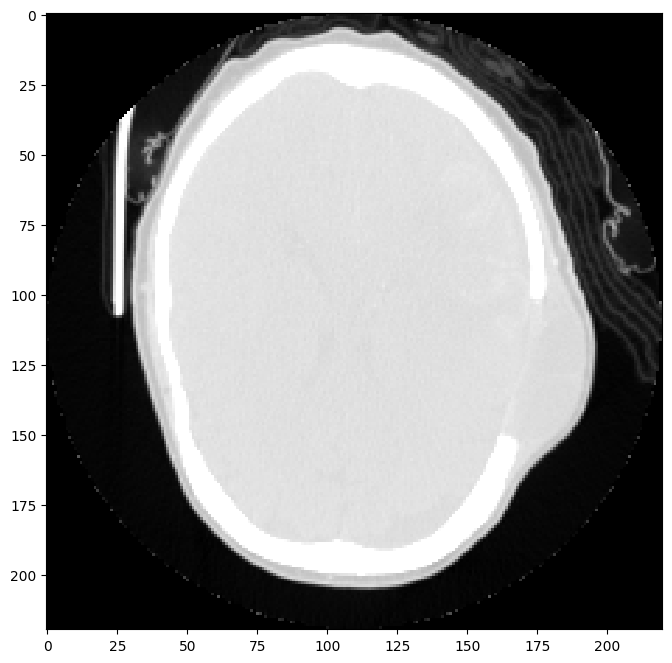

In [6]:
# img_ref = img[:, [img.shape[1]//2], ...]
img_ref = np.copy(img)
print(img_ref.shape)
plt.figure(figsize=[8, 8])
plt.imshow(img_ref[0, 30], 'gray', vmin=0, vmax=1.2)

In [7]:
projector = ct_projector.ct_projector()
projector.from_file('projector_fan.cfg')
projector.nv = 1
projector.nz = 1
projector.ny = img_ref.shape[2]
projector.nx = img_ref.shape[3]
projector.du = projector.du * projector.dso / projector.dsd
angles = projector.get_angles()

In [11]:
origin_img = img_ref[0,...]
origin_img = origin_img[:,np.newaxis,...]
print(origin_img.shape)

(66, 1, 220, 220)


In [8]:
cp.cuda.Device(device).use()

curef = cp.array(original, order='C')
cuangles = cp.array(angles, order='C')

projector.set_projector(ct_para.distance_driven_fp, angles=cuangles)
projector.set_backprojector(ct_para.distance_driven_bp, angles=cuangles)

(1, 1, 220, 220)


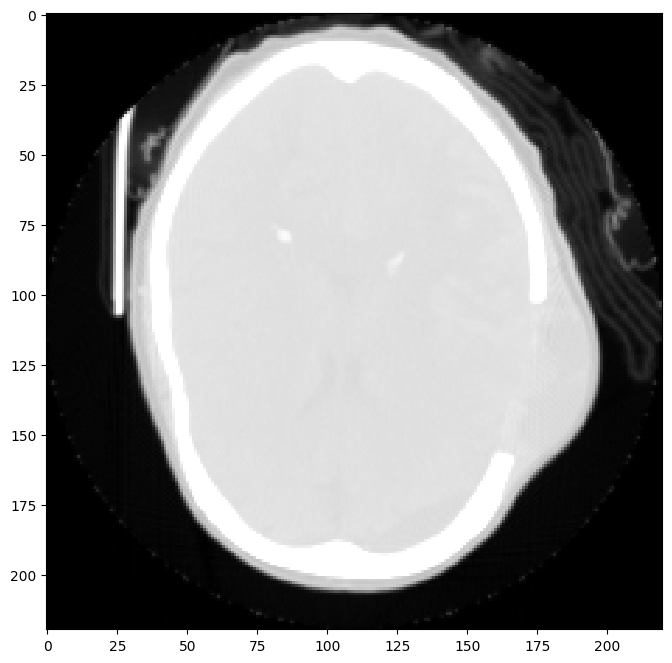

In [10]:
cuprj = projector.fp(curef, angles=cuangles)
prj = cuprj.get()
fprj = ct_para_numpy.ramp_filter(projector, prj, 'rl')
fbp = ct_para_numpy.distance_driven_bp(projector, fprj, angles, True)
print(fbp.shape)

plt.figure(figsize=[8, 8])
plt.imshow(fbp[0, 0], 'gray', vmin=0, vmax=1.2)

In [27]:
# TV reconstruction
niter = 50
nos = 12  ######## what's os and nos?
nesterov = 0.5
beta = 0.001
zero_init = False

projector_norm = projector.calc_projector_norm()
cunorm_img = projector.calc_norm_img() / projector_norm / projector_norm

cufbp = cp.array(fbp, order='C')
if zero_init:
    curecon = cp.zeros(cufbp.shape, cp.float32)
    cunesterov = cp.zeros(cufbp.shape, cp.float32)
else:    
    curecon = cp.copy(cufbp)
    cunesterov = cp.copy(curecon)

for i in range(niter):
    for os in range(nos):
        inds = np.arange(os, len(cuangles), nos)   ##### pick a projection view every nos view and do this in an incremental way?
        cuangles_current = cp.copy(cuangles[inds], 'C')
        cuprj_current = cp.copy(cuprj[:, inds, ...], 'C')

        curecon, cunesterov = ct_recon.nesterov_acceleration(
            ct_recon.sqs_gaussian_one_step,
            img=curecon,
            img_nesterov=cunesterov,
            recon_kwargs={
                'projector': projector,
                'prj': cuprj,
                'norm_img': cunorm_img,
                'projector_norm': projector_norm,
                'beta': beta
            }
        )

    if (i + 1) % 10 == 0:
        _, data_loss, prior_loss = ct_recon.sqs_gaussian_one_step(
            projector,
            curecon,
            cuprj,
            cunorm_img,
            projector_norm,
            beta,
            return_loss=True
        )

        print(i + 1, data_loss, prior_loss)

0,1,2,3,4,5,6,7,8,9,
10 0.100226365 621.4403
20 0.105545655 615.1384
30 0.10745694 613.0953
40 0.10809383 612.43646
50 0.10830348 612.222


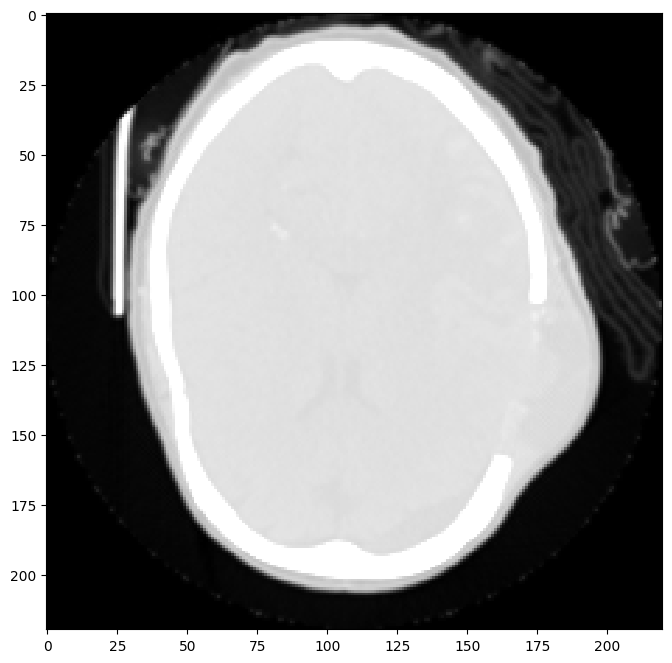

In [28]:
recon = curecon.get()
plt.figure(figsize=[8, 8])
plt.imshow(recon[0, 0], 'gray', vmin=0, vmax=1.2)

0.0043372074


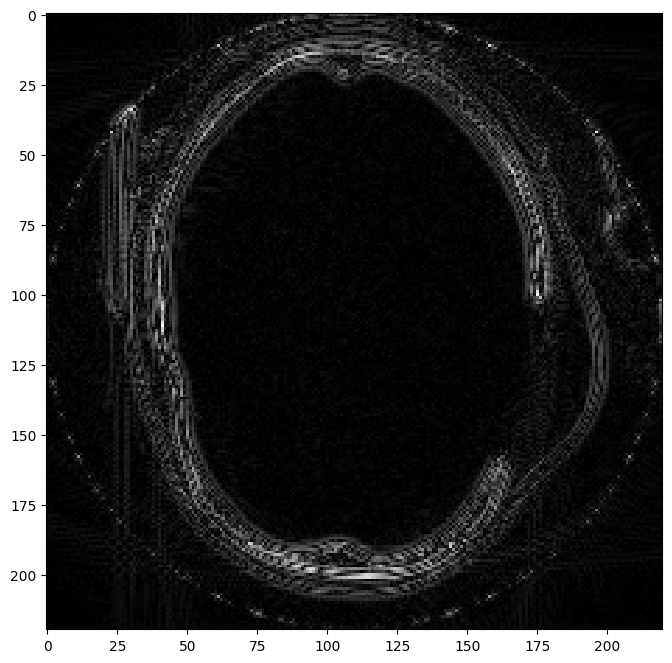

In [29]:
delta = np.abs(recon - fbp)
print(np.mean(delta))

plt.figure(figsize=[8, 8])
plt.imshow(delta[0, 0], 'gray')